# Dynamic Pricing Model

Machine learning model to optimize product prices based on competitor data, demand patterns, inventory levels, and customer behavior.

## Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
products = pd.read_csv('csv_data/products.csv')
categories = pd.read_csv('csv_data/categories.csv')
customers = pd.read_csv('csv_data/customers.csv')
competitors = pd.read_csv('csv_data/competitors.csv')
inventory = pd.read_csv('csv_data/inventory.csv')
orders = pd.read_csv('csv_data/orders.csv')
order_items = pd.read_csv('csv_data/order_items.csv')
demand_metrics = pd.read_csv('csv_data/demand_metrics.csv')
competitor_prices = pd.read_csv('csv_data/competitor_prices.csv')
pricing_history = pd.read_csv('csv_data/pricing_history.csv')

## Explore Price Distribution

In [4]:
products[['base_price', 'current_price', 'min_price', 'max_price']].describe()

,base_price,current_price,min_price,max_price
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,6029.412075,6025.913347,4220.588126,9044.118106
std,3911.747124,3929.693289,2738.222989,5867.620689
min,8.240000,7.900000,5.770000,12.360000
25%,2811.532500,2796.682500,1968.075000,4217.300000
50%,5598.345000,5577.075000,3918.840000,8397.520000
75%,8689.335000,8675.630000,6082.535000,13034.002500
max,17296.600000,18937.100000,12107.620000,25944.900000


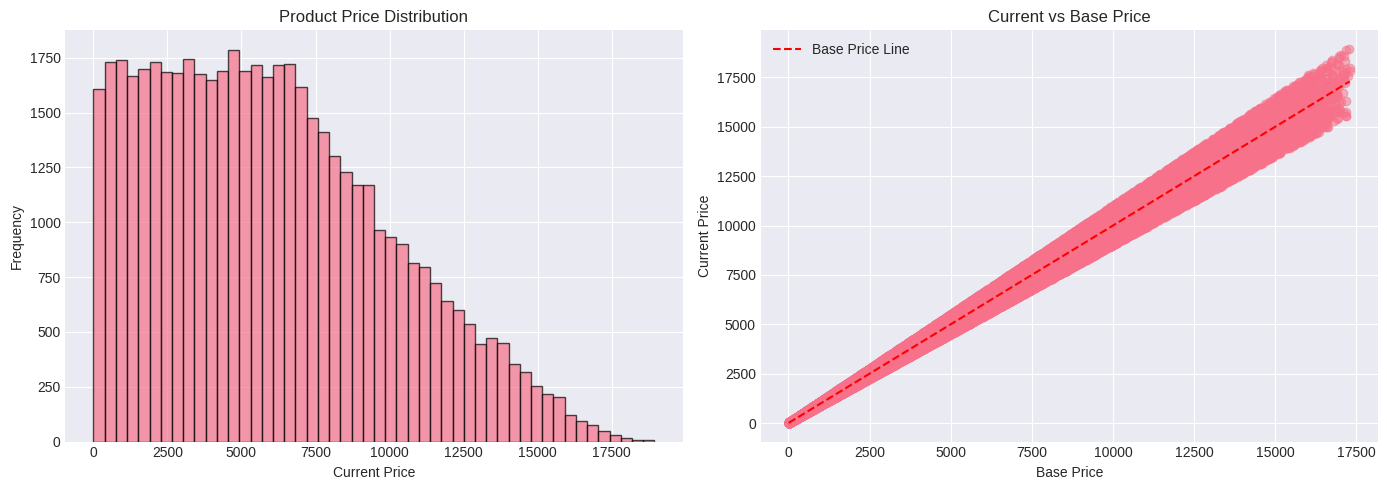

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(products['current_price'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Current Price')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Product Price Distribution')

axes[1].scatter(products['base_price'], products['current_price'], alpha=0.5)
axes[1].plot([products['base_price'].min(), products['base_price'].max()], 
             [products['base_price'].min(), products['base_price'].max()], 
             'r--', label='Base Price Line')
axes[1].set_xlabel('Base Price')
axes[1].set_ylabel('Current Price')
axes[1].set_title('Current vs Base Price')
axes[1].legend()

plt.tight_layout()
plt.show()

## Build Features

Extract competitor pricing patterns

In [6]:
competitor_features = competitor_prices.groupby('product_id').agg({
    'competitor_price': ['mean', 'min', 'max', 'std', 'count']
}).reset_index()

competitor_features.columns = ['product_id', 'competitor_price_avg', 'competitor_price_min', 
                                'competitor_price_max', 'competitor_price_std', 'competitor_count']

competitor_features['competitor_price_std'].fillna(0, inplace=True)

Calculate demand metrics from last 30 days

In [7]:
demand_metrics['date'] = pd.to_datetime(demand_metrics['date'])
recent_date = demand_metrics['date'].max()
recent_cutoff = recent_date - pd.Timedelta(days=30)

recent_demand = demand_metrics[demand_metrics['date'] > recent_cutoff]

demand_features = recent_demand.groupby('product_id').agg({
    'page_views': 'sum',
    'add_to_cart_count': 'sum',
    'purchase_count': 'sum',
    'conversion_rate': 'mean',
    'cart_abandonment_rate': 'mean',
    'revenue': 'sum',
    'demand_score': 'mean'
}).reset_index()

demand_features.columns = ['product_id', 'total_views_30d', 'total_cart_adds_30d', 
                           'total_purchases_30d', 'avg_conversion_rate', 
                           'avg_abandonment_rate', 'total_revenue_30d', 'avg_demand_score']

In [8]:
sales_features = order_items.groupby('product_id').agg({
    'quantity': 'sum',
    'total_price': 'sum',
    'order_id': 'count'
}).reset_index()

sales_features.columns = ['product_id', 'total_units_sold', 'total_sales_revenue', 'total_orders']
sales_features['avg_order_value'] = (sales_features['total_sales_revenue'] / 
                                     sales_features['total_orders']).round(2)

In [9]:
pricing_data = products.copy()

pricing_data = pricing_data.merge(inventory[['product_id', 'quantity_available', 'stock_status']], 
                                  on='product_id', how='left')

pricing_data = pricing_data.merge(competitor_features, on='product_id', how='left')

pricing_data = pricing_data.merge(demand_features, on='product_id', how='left')

pricing_data = pricing_data.merge(sales_features, on='product_id', how='left')

pricing_data = pricing_data.merge(categories[['category_id', 'category_name']], 
                                  on='category_id', how='left')

Create derived features for better predictions

In [10]:
pricing_data['price_position_vs_competitors'] = (
    (pricing_data['current_price'] - pricing_data['competitor_price_avg']) / 
    pricing_data['competitor_price_avg'] * 100
)

pricing_data['inventory_turnover'] = (
    pricing_data['total_units_sold'] / pricing_data['quantity_available']
)

pricing_data['revenue_per_view'] = (
    pricing_data['total_revenue_30d'] / pricing_data['total_views_30d']
)

pricing_data['profit_margin'] = (
    (pricing_data['current_price'] - pricing_data['base_cost']) / pricing_data['current_price'] * 100
)

pricing_data['price_elasticity_proxy'] = (
    pricing_data['total_purchases_30d'] / pricing_data['current_price']
)

pricing_data.fillna(0, inplace=True)
pricing_data.replace([np.inf, -np.inf], 0, inplace=True)

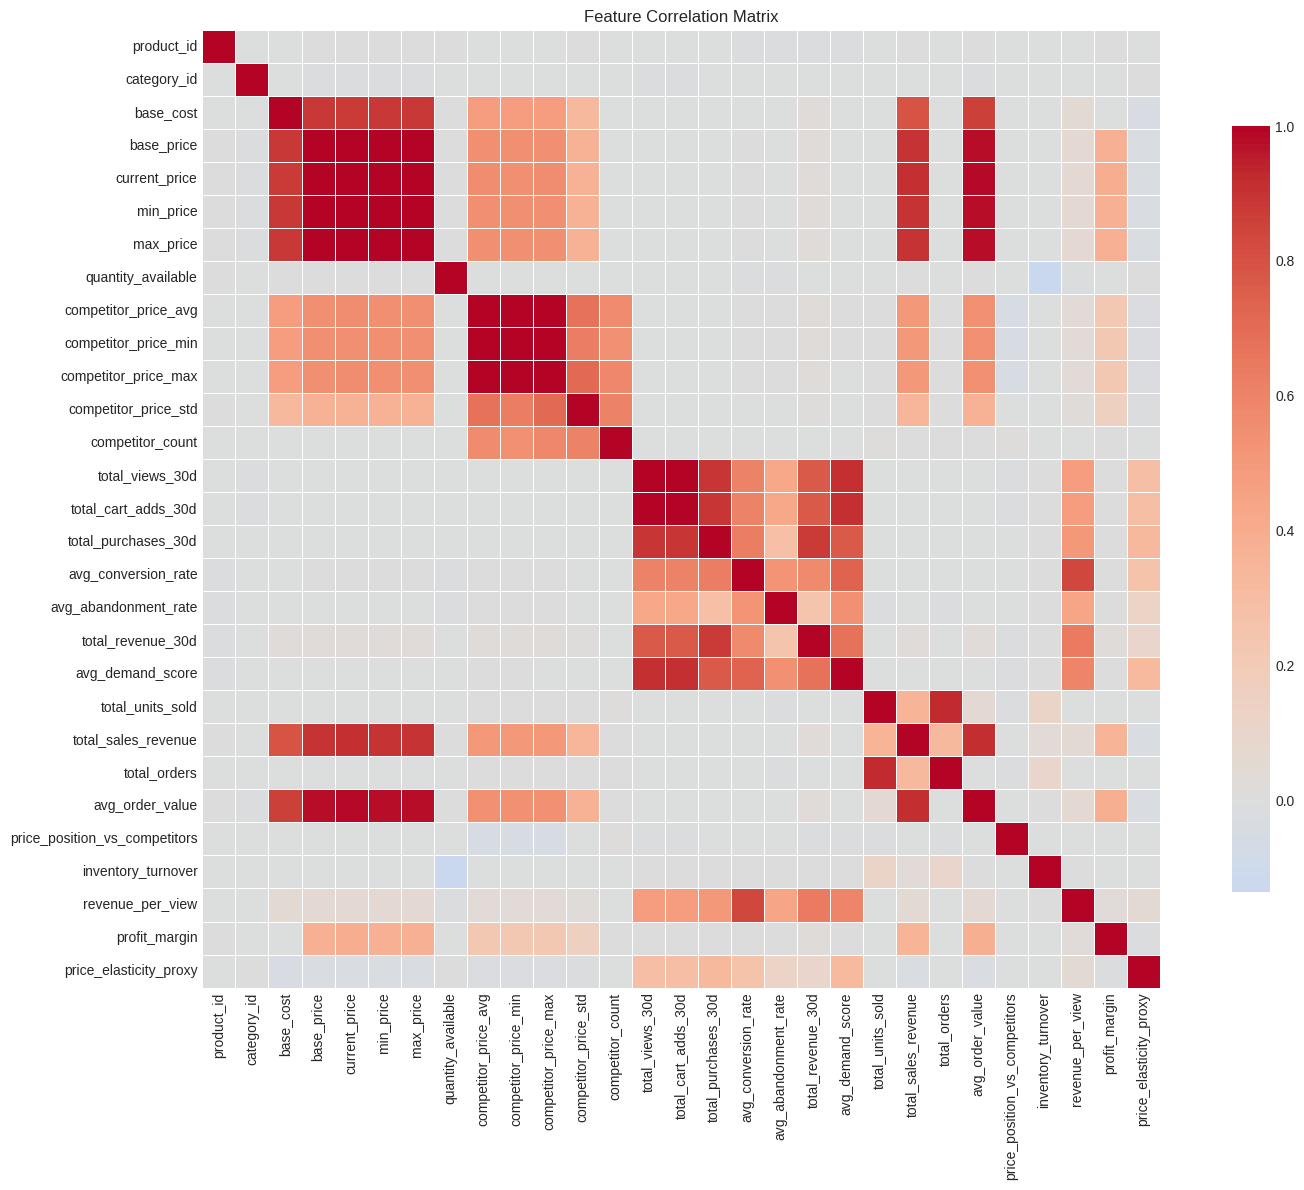

current_price           1.000000
max_price               0.994386
base_price              0.994386
min_price               0.994386
avg_order_value         0.983661
total_sales_revenue     0.905850
base_cost               0.877753
competitor_price_avg    0.553162
competitor_price_max    0.552592
competitor_price_min    0.551979
Name: current_price, dtype: float64

In [11]:
numeric_cols = pricing_data.select_dtypes(include=[np.number]).columns
correlation_matrix = pricing_data[numeric_cols].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

correlation_matrix['current_price'].sort_values(ascending=False).head(10)

## Prepare Model Data

In [12]:
feature_columns = [
    'base_price', 'base_cost', 'min_price', 'max_price',
    'quantity_available',
    'competitor_price_avg', 'competitor_price_min', 'competitor_price_max', 
    'competitor_price_std', 'competitor_count',
    'total_views_30d', 'total_cart_adds_30d', 'total_purchases_30d',
    'avg_conversion_rate', 'avg_abandonment_rate', 'avg_demand_score',
    'total_units_sold', 'total_orders', 'avg_order_value',
    'price_position_vs_competitors', 'inventory_turnover',
    'revenue_per_view', 'profit_margin', 'price_elasticity_proxy'
]

target_column = 'current_price'

model_data = pricing_data[feature_columns + [target_column]].copy()
model_data = model_data.replace([np.inf, -np.inf], 0).fillna(0)

In [13]:
X = model_data[feature_columns]
y = model_data[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Train Models

In [14]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = r2_score(y_test, rf_predictions)

In [15]:
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)

gb_mae = mean_absolute_error(y_test, gb_predictions)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_predictions))
gb_r2 = r2_score(y_test, gb_predictions)

In [16]:
model_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting'],
    'MAE': [rf_mae, gb_mae],
    'RMSE': [rf_rmse, gb_rmse],
    'R² Score': [rf_r2, gb_r2]
})

best_model = rf_model if rf_r2 > gb_r2 else gb_model
best_model_name = 'Random Forest' if rf_r2 > gb_r2 else 'Gradient Boosting'

model_comparison

,Model,MAE,RMSE,R² Score
0,Random Forest,111.327587,161.653508,0.998315
1,Gradient Boosting,96.115979,130.762640,0.998897


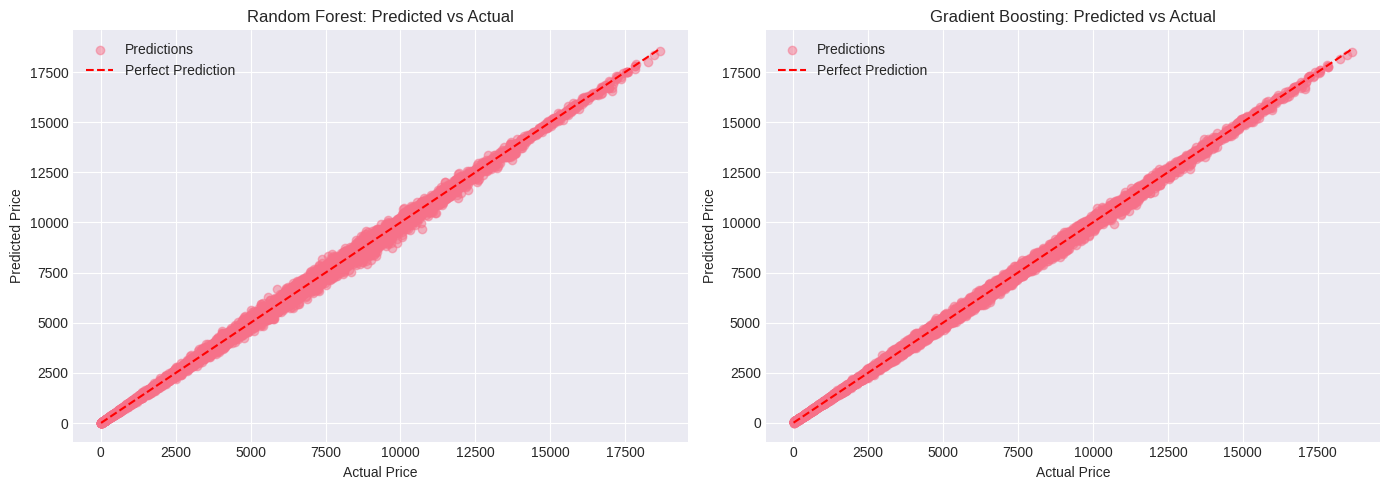

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_test, rf_predictions, alpha=0.5, label='Predictions')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', label='Perfect Prediction')
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].set_title('Random Forest: Predicted vs Actual')
axes[0].legend()

axes[1].scatter(y_test, gb_predictions, alpha=0.5, label='Predictions')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', label='Perfect Prediction')
axes[1].set_xlabel('Actual Price')
axes[1].set_ylabel('Predicted Price')
axes[1].set_title('Gradient Boosting: Predicted vs Actual')
axes[1].legend()

plt.tight_layout()
plt.show()

## Feature Importance

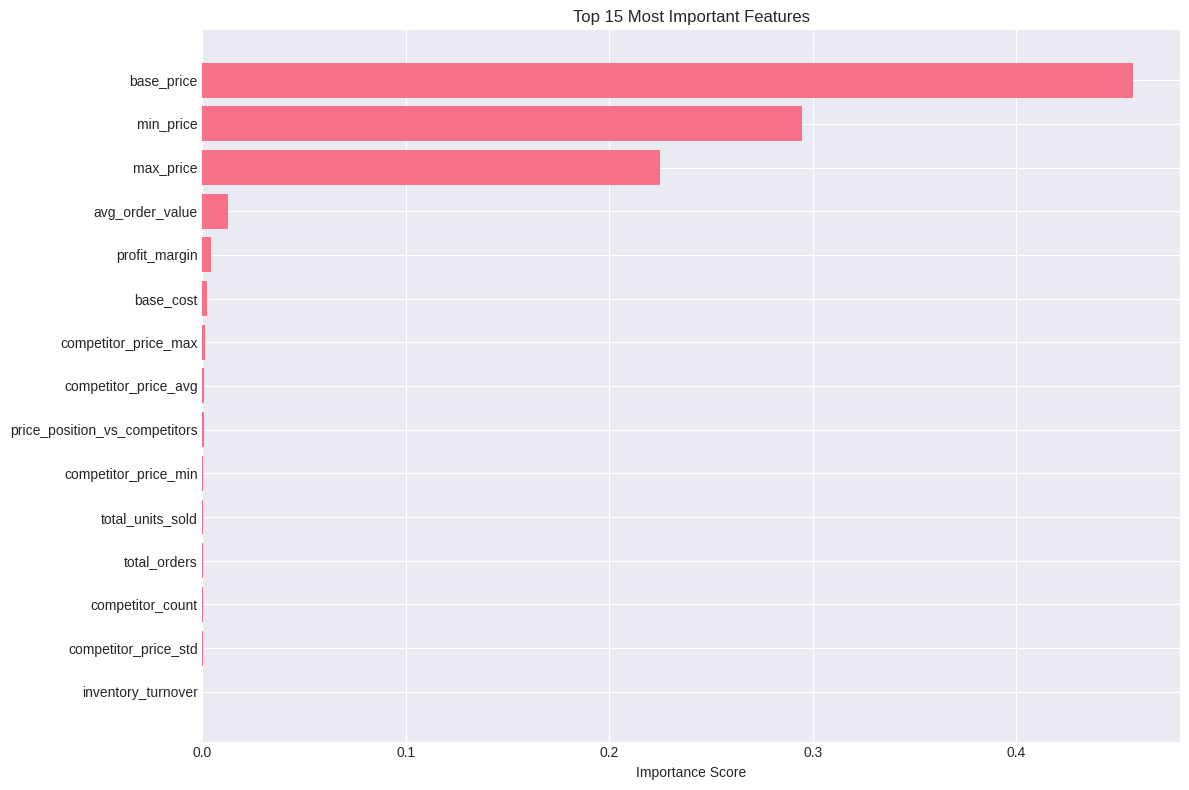

,feature,importance
0,base_price,0.457676
2,min_price,0.294777
3,max_price,0.225141
18,avg_order_value,0.012729
22,profit_margin,0.004160
1,base_cost,0.002320
7,competitor_price_max,0.001173
5,competitor_price_avg,0.000755
19,price_position_vs_competitors,0.000591
6,competitor_price_min,0.000222


In [18]:
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance['feature'].head(15), feature_importance['importance'].head(15))
plt.xlabel('Importance Score')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

feature_importance.head(10)

## Apply Pricing Strategy

In [19]:
def calculate_optimal_price(row, ml_prediction):
    current_price = row['current_price']
    min_price = row['min_price']
    max_price = row['max_price']
    base_price = row['base_price']
    
    competitor_avg = row['competitor_price_avg']
    demand_score = row['avg_demand_score']
    stock_level = row['quantity_available']
    conversion_rate = row['avg_conversion_rate']
    
    recommended_price = ml_prediction
    strategy = []
    adjustment = 0
    
    if demand_score > 8 and stock_level > 100:
        adjustment += 0.05
        strategy.append('high_demand_premium')
    
    if demand_score < 4 and stock_level > 500:
        adjustment -= 0.10
        strategy.append('clearance_discount')
    
    if competitor_avg > 0 and current_price > competitor_avg * 1.1:
        adjustment -= 0.05
        strategy.append('competitive_adjustment')
    
    if stock_level < 50 and demand_score > 6:
        adjustment += 0.08
        strategy.append('scarcity_premium')
    
    if conversion_rate < 1.5 and demand_score < 5:
        adjustment -= 0.07
        strategy.append('boost_conversion')
    
    recommended_price = recommended_price * (1 + adjustment)
    recommended_price = max(min_price, min(recommended_price, max_price))
    
    confidence = min(100, 70 + abs(adjustment) * 500)
    
    return recommended_price, ','.join(strategy) if strategy else 'maintain_current', confidence

In [20]:
all_predictions = best_model.predict(X)
pricing_data['ml_predicted_price'] = all_predictions

results = pricing_data.apply(
    lambda row: calculate_optimal_price(row, row['ml_predicted_price']), 
    axis=1
)

pricing_data['recommended_price'] = [r[0] for r in results]
pricing_data['strategy'] = [r[1] for r in results]
pricing_data['confidence'] = [r[2] for r in results]

pricing_data['price_change'] = pricing_data['recommended_price'] - pricing_data['current_price']
pricing_data['price_change_pct'] = (pricing_data['price_change'] / pricing_data['current_price'] * 100).round(2)

Top products for price increase

In [21]:
increase_recommendations = pricing_data[pricing_data['price_change'] > 0].nlargest(10, 'price_change')

display_cols = ['product_name', 'current_price', 'recommended_price', 
                'price_change', 'price_change_pct', 'strategy', 'confidence']

increase_recommendations[display_cols]

,product_name,current_price,recommended_price,price_change,price_change_pct,strategy,confidence
34507,Deluxe Pack 34508,13684.14,14859.702151,1175.562151,8.59,scarcity_premium,100.0
30401,Deluxe System 30402,13684.93,14821.130702,1136.200702,8.30,scarcity_premium,100.0
7370,Wireless Pack 07371,13630.86,14750.002076,1119.142076,8.21,scarcity_premium,100.0
47409,Standard Tool 47410,11223.56,12273.489106,1049.929106,9.35,scarcity_premium,100.0
37508,Compact Bundle 37509,12814.17,13770.335096,956.165096,7.46,scarcity_premium,100.0
2929,Wireless System 02930,10735.04,11618.086102,883.046102,8.23,scarcity_premium,100.0
33546,Standard Collection 33547,11253.32,12131.491931,878.171931,7.80,scarcity_premium,100.0
24678,Compact Set 24679,9937.18,10800.556463,863.376463,8.69,scarcity_premium,100.0
31800,Standard Collection 31801,8229.08,9019.420254,790.340254,9.60,scarcity_premium,100.0
9885,Smart Pack 09886,11531.82,12298.790437,766.970437,6.65,high_demand_premium,95.0


Top products for price decrease

In [22]:
decrease_recommendations = pricing_data[pricing_data['price_change'] < 0].nsmallest(10, 'price_change')

decrease_recommendations[display_cols]

,product_name,current_price,recommended_price,price_change,price_change_pct,strategy,confidence
7667,Portable Unit 07668,16721.53,12969.174545,-3752.355455,-22.44,"clearance_discount,competitive_adjustment,boos...",100.0
15875,Standard System 15876,16237.79,12598.863960,-3638.926040,-22.41,"clearance_discount,competitive_adjustment,boos...",100.0
37458,Basic Pack 37459,16366.53,12745.683684,-3620.846316,-22.12,"clearance_discount,competitive_adjustment,boos...",100.0
890,Portable Pack 00891,15813.08,12206.923454,-3606.156546,-22.80,"clearance_discount,competitive_adjustment,boos...",100.0
29045,Portable Bundle 29046,14804.82,11383.935299,-3420.884701,-23.11,"clearance_discount,competitive_adjustment,boos...",100.0
26555,Advanced Collection 26556,15529.44,12129.255348,-3400.184652,-21.90,"clearance_discount,competitive_adjustment,boos...",100.0
4970,Deluxe Tool 04971,15633.12,12250.641713,-3382.478287,-21.64,"clearance_discount,competitive_adjustment,boos...",100.0
24888,Premium Device 24889,14493.71,11152.435103,-3341.274897,-23.05,"clearance_discount,competitive_adjustment,boos...",100.0
12093,Standard Series 12094,14840.89,11561.534651,-3279.355349,-22.10,"clearance_discount,competitive_adjustment,boos...",100.0
35379,Deluxe Tool 35380,15013.50,11781.848928,-3231.651072,-21.52,"clearance_discount,competitive_adjustment,boos...",100.0


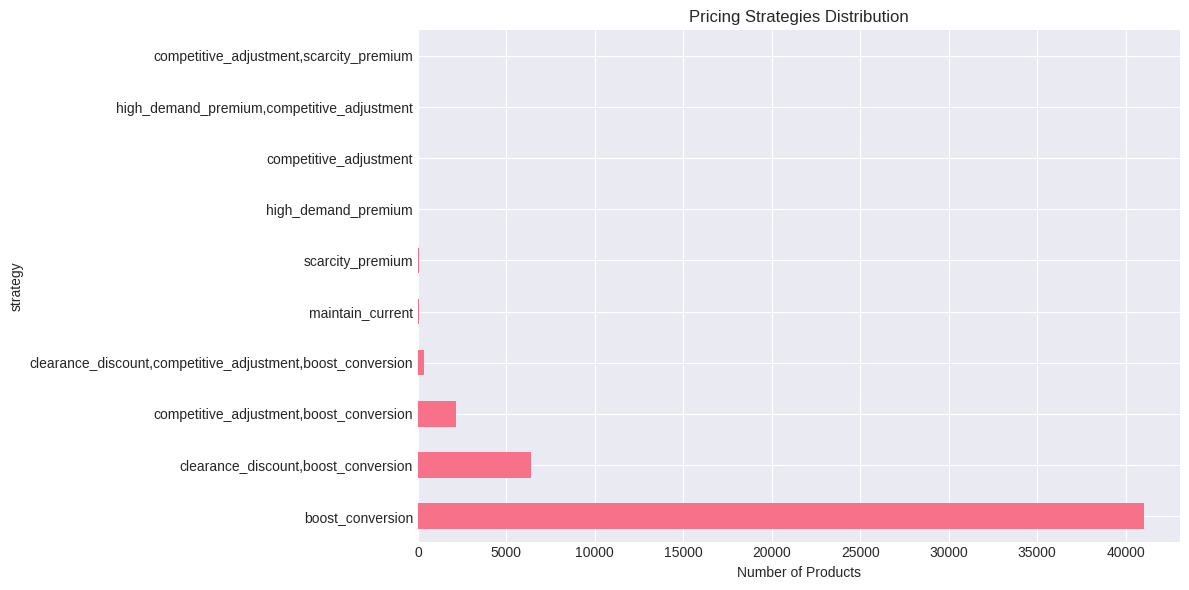

strategy
boost_conversion                                              41025
clearance_discount,boost_conversion                            6385
competitive_adjustment,boost_conversion                        2151
clearance_discount,competitive_adjustment,boost_conversion      320
maintain_current                                                 51
scarcity_premium                                                 45
high_demand_premium                                              18
competitive_adjustment                                            3
high_demand_premium,competitive_adjustment                        1
competitive_adjustment,scarcity_premium                           1
Name: count, dtype: int64

In [23]:
strategy_counts = pricing_data['strategy'].value_counts()

plt.figure(figsize=(12, 6))
strategy_counts.plot(kind='barh')
plt.xlabel('Number of Products')
plt.title('Pricing Strategies Distribution')
plt.tight_layout()
plt.show()

strategy_counts

## Calculate Revenue Impact

In [24]:
pricing_data['estimated_units'] = pricing_data['total_purchases_30d'].fillna(0)

pricing_data['current_revenue_projection'] = (
    pricing_data['current_price'] * pricing_data['estimated_units']
)

pricing_data['recommended_revenue_projection'] = (
    pricing_data['recommended_price'] * pricing_data['estimated_units']
)

pricing_data['revenue_impact'] = (
    pricing_data['recommended_revenue_projection'] - pricing_data['current_revenue_projection']
)

current_total_revenue = pricing_data['current_revenue_projection'].sum()
recommended_total_revenue = pricing_data['recommended_revenue_projection'].sum()
total_revenue_impact = recommended_total_revenue - current_total_revenue
revenue_change_pct = (total_revenue_impact / current_total_revenue * 100)

pd.DataFrame({
    'Metric': ['Current Revenue', 'Recommended Revenue', 'Impact', 'Change %'],
    'Value': [f'${current_total_revenue:,.2f}', f'${recommended_total_revenue:,.2f}', 
              f'${total_revenue_impact:,.2f}', f'{revenue_change_pct:+.2f}%']
})

,Metric,Value
0,Current Revenue,"$340,036,335.84"
1,Recommended Revenue,"$337,458,192.74"
2,Impact,"$-2,578,143.10"
3,Change %,-0.76%


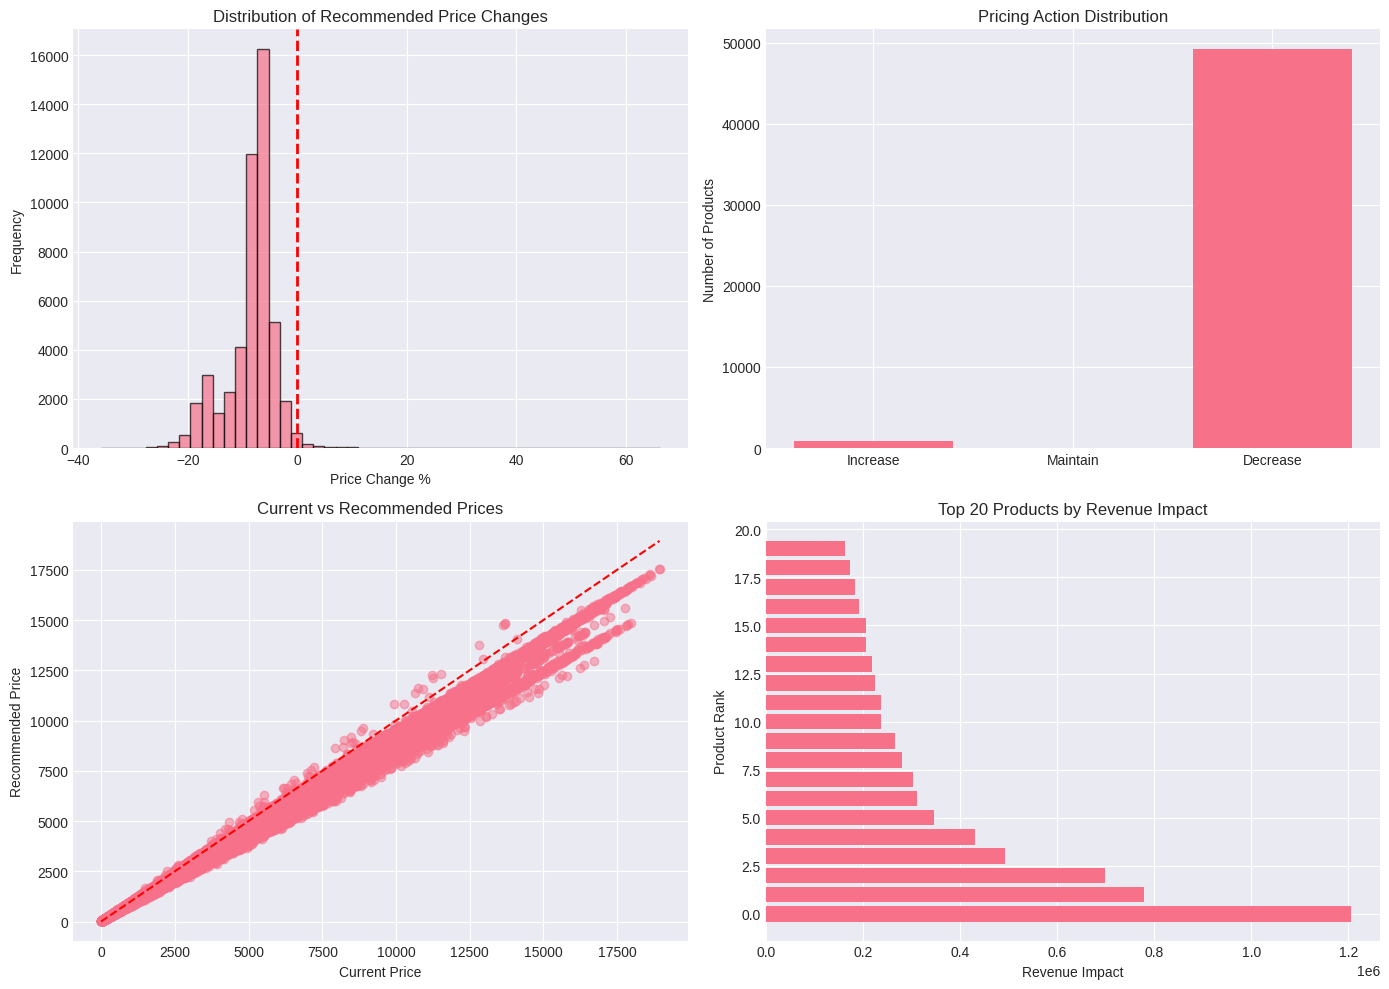

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(pricing_data['price_change_pct'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Price Change %')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Recommended Price Changes')

increase_count = len(pricing_data[pricing_data['price_change'] > 0])
decrease_count = len(pricing_data[pricing_data['price_change'] < 0])
maintain_count = len(pricing_data[pricing_data['price_change'] == 0])

axes[0, 1].bar(['Increase', 'Maintain', 'Decrease'], 
               [increase_count, maintain_count, decrease_count])
axes[0, 1].set_ylabel('Number of Products')
axes[0, 1].set_title('Pricing Action Distribution')

axes[1, 0].scatter(pricing_data['current_price'], pricing_data['recommended_price'], alpha=0.5)
axes[1, 0].plot([0, pricing_data['current_price'].max()], 
                [0, pricing_data['current_price'].max()], 'r--')
axes[1, 0].set_xlabel('Current Price')
axes[1, 0].set_ylabel('Recommended Price')
axes[1, 0].set_title('Current vs Recommended Prices')

top_impact = pricing_data.nlargest(20, 'revenue_impact')
axes[1, 1].barh(range(len(top_impact)), top_impact['revenue_impact'])
axes[1, 1].set_xlabel('Revenue Impact')
axes[1, 1].set_ylabel('Product Rank')
axes[1, 1].set_title('Top 20 Products by Revenue Impact')

plt.tight_layout()
plt.show()

Category analysis by revenue impact

In [26]:
category_analysis = pricing_data.groupby('category_name').agg({
    'product_id': 'count',
    'current_price': 'mean',
    'recommended_price': 'mean',
    'price_change': 'mean',
    'revenue_impact': 'sum',
    'confidence': 'mean'
}).round(2)

category_analysis.columns = ['product_count', 'avg_current_price', 'avg_recommended_price',
                              'avg_price_change', 'total_revenue_impact', 'avg_confidence']

category_analysis.sort_values('total_revenue_impact', ascending=False).head(10)

,product_count,avg_current_price,avg_recommended_price,avg_price_change,total_revenue_impact,avg_confidence
category_name,,,,,,
Professional Jewelry,1021,6121.37,5598.52,-522.85,731187.92,99.97
Music & Instruments,986,6133.09,5608.95,-524.14,667888.89,99.97
Books,992,6183.21,5656.17,-527.04,547538.73,100.00
Premium Music & Instruments,1005,6009.89,5499.79,-510.10,440763.99,99.99
Beginner Clothing,963,5862.93,5348.51,-514.41,309315.59,99.97
Jewelry,1019,5928.22,5424.22,-504.00,285724.16,99.97
Food & Grocery,962,5959.05,5424.91,-534.14,207844.13,99.94
Pet Supplies,997,6007.57,5485.59,-521.98,197554.03,99.99
Premium Pet Supplies,1013,5920.38,5406.86,-513.52,143541.87,99.97


## Export Results

In [27]:
export_columns = [
    'product_id', 'product_name', 'category_name', 'brand',
    'current_price', 'recommended_price', 'price_change', 'price_change_pct',
    'min_price', 'max_price', 'strategy', 'confidence',
    'avg_demand_score', 'quantity_available', 'competitor_price_avg',
    'revenue_impact'
]

recommendations_export = pricing_data[export_columns].copy()

significant_changes = recommendations_export[
    (abs(recommendations_export['price_change_pct']) > 2) &
    (recommendations_export['confidence'] > 60)
]

recommendations_export.to_csv('csv_data/pricing_recommendations_all.csv', index=False)
significant_changes.to_csv('csv_data/pricing_recommendations_priority.csv', index=False)

f"Saved {len(significant_changes)} priority recommendations"

'Saved 48742 priority recommendations'

Category analysis by revenue impact

In [28]:
export_columns = [
    'product_id', 'product_name', 'category_name', 'brand',
    'current_price', 'recommended_price', 'price_change', 'price_change_pct',
    'min_price', 'max_price', 'strategy', 'confidence',
    'avg_demand_score', 'quantity_available', 'competitor_price_avg',
    'revenue_impact'
]

recommendations_export = pricing_data[export_columns].copy()

significant_changes = recommendations_export[
    (abs(recommendations_export['price_change_pct']) > 2) &
    (recommendations_export['confidence'] > 60)
]

recommendations_export.to_csv('csv_data/pricing_recommendations_all.csv', index=False)
significant_changes.to_csv('csv_data/pricing_recommendations_priority.csv', index=False)

f"Saved {len(significant_changes)} priority recommendations"

'Saved 48742 priority recommendations'

## Calculate Revenue Impact

In [29]:
category_analysis = pricing_data.groupby('category_name').agg({
    'product_id': 'count',
    'current_price': 'mean',
    'recommended_price': 'mean',
    'price_change': 'mean',
    'revenue_impact': 'sum',
    'confidence': 'mean'
}).round(2)

category_analysis.columns = ['product_count', 'avg_current_price', 'avg_recommended_price',
                              'avg_price_change', 'total_revenue_impact', 'avg_confidence']

category_analysis.sort_values('total_revenue_impact', ascending=False).head(10)

,product_count,avg_current_price,avg_recommended_price,avg_price_change,total_revenue_impact,avg_confidence
category_name,,,,,,
Professional Jewelry,1021,6121.37,5598.52,-522.85,731187.92,99.97
Music & Instruments,986,6133.09,5608.95,-524.14,667888.89,99.97
Books,992,6183.21,5656.17,-527.04,547538.73,100.00
Premium Music & Instruments,1005,6009.89,5499.79,-510.10,440763.99,99.99
Beginner Clothing,963,5862.93,5348.51,-514.41,309315.59,99.97
Jewelry,1019,5928.22,5424.22,-504.00,285724.16,99.97
Food & Grocery,962,5959.05,5424.91,-534.14,207844.13,99.94
Pet Supplies,997,6007.57,5485.59,-521.98,197554.03,99.99
Premium Pet Supplies,1013,5920.38,5406.86,-513.52,143541.87,99.97


Top products for price decrease

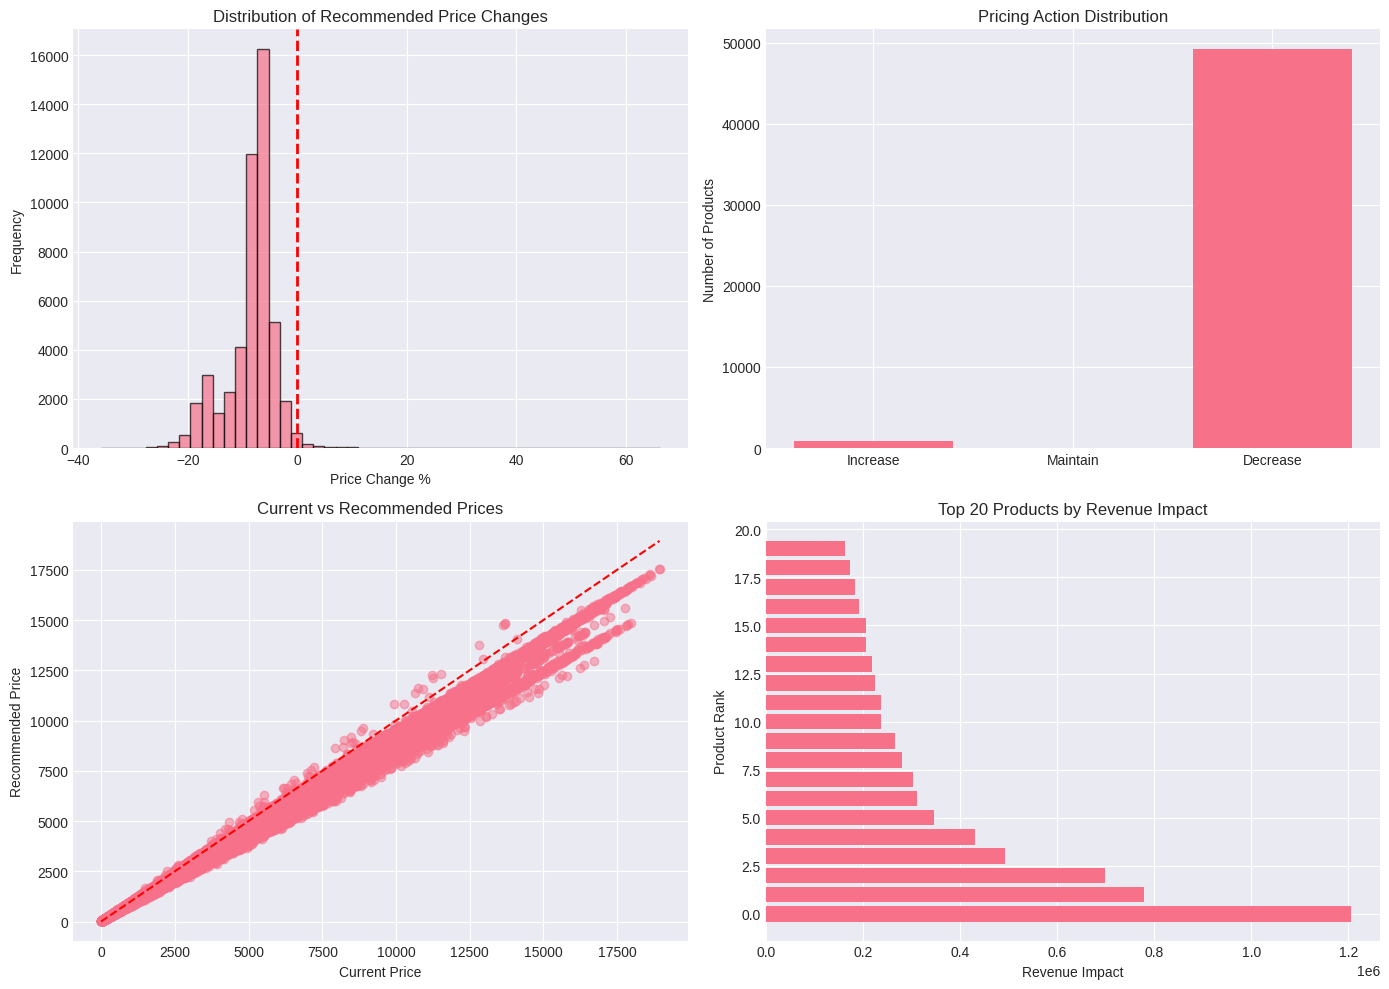

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(pricing_data['price_change_pct'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Price Change %')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Recommended Price Changes')

increase_count = len(pricing_data[pricing_data['price_change'] > 0])
decrease_count = len(pricing_data[pricing_data['price_change'] < 0])
maintain_count = len(pricing_data[pricing_data['price_change'] == 0])

axes[0, 1].bar(['Increase', 'Maintain', 'Decrease'], 
               [increase_count, maintain_count, decrease_count])
axes[0, 1].set_ylabel('Number of Products')
axes[0, 1].set_title('Pricing Action Distribution')

axes[1, 0].scatter(pricing_data['current_price'], pricing_data['recommended_price'], alpha=0.5)
axes[1, 0].plot([0, pricing_data['current_price'].max()], 
                [0, pricing_data['current_price'].max()], 'r--')
axes[1, 0].set_xlabel('Current Price')
axes[1, 0].set_ylabel('Recommended Price')
axes[1, 0].set_title('Current vs Recommended Prices')

top_impact = pricing_data.nlargest(20, 'revenue_impact')
axes[1, 1].barh(range(len(top_impact)), top_impact['revenue_impact'])
axes[1, 1].set_xlabel('Revenue Impact')
axes[1, 1].set_ylabel('Product Rank')
axes[1, 1].set_title('Top 20 Products by Revenue Impact')

plt.tight_layout()
plt.show()

In [31]:
pricing_data['estimated_units'] = pricing_data['total_purchases_30d'].fillna(0)

pricing_data['current_revenue_projection'] = (
    pricing_data['current_price'] * pricing_data['estimated_units']
)

pricing_data['recommended_revenue_projection'] = (
    pricing_data['recommended_price'] * pricing_data['estimated_units']
)

pricing_data['revenue_impact'] = (
    pricing_data['recommended_revenue_projection'] - pricing_data['current_revenue_projection']
)

current_total_revenue = pricing_data['current_revenue_projection'].sum()
recommended_total_revenue = pricing_data['recommended_revenue_projection'].sum()
total_revenue_impact = recommended_total_revenue - current_total_revenue
revenue_change_pct = (total_revenue_impact / current_total_revenue * 100)

pd.DataFrame({
    'Metric': ['Current Revenue', 'Recommended Revenue', 'Impact', 'Change %'],
    'Value': [f'${current_total_revenue:,.2f}', f'${recommended_total_revenue:,.2f}', 
              f'${total_revenue_impact:,.2f}', f'{revenue_change_pct:+.2f}%']
})

,Metric,Value
0,Current Revenue,"$340,036,335.84"
1,Recommended Revenue,"$337,458,192.74"
2,Impact,"$-2,578,143.10"
3,Change %,-0.76%


Top products for price increase

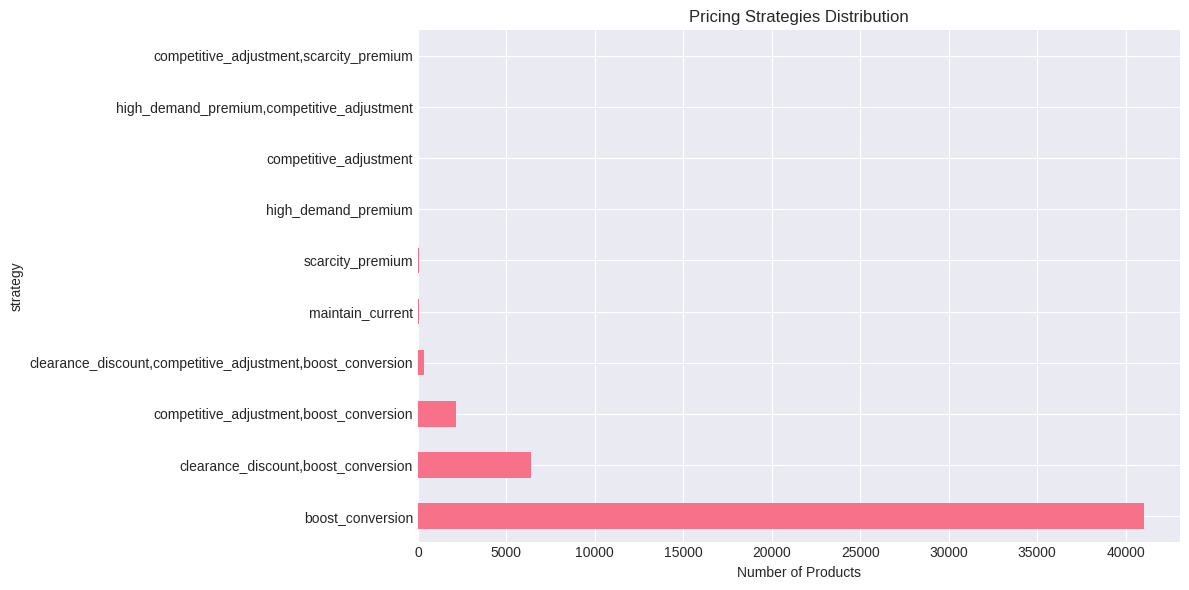

strategy
boost_conversion                                              41025
clearance_discount,boost_conversion                            6385
competitive_adjustment,boost_conversion                        2151
clearance_discount,competitive_adjustment,boost_conversion      320
maintain_current                                                 51
scarcity_premium                                                 45
high_demand_premium                                              18
competitive_adjustment                                            3
high_demand_premium,competitive_adjustment                        1
competitive_adjustment,scarcity_premium                           1
Name: count, dtype: int64

In [32]:
strategy_counts = pricing_data['strategy'].value_counts()

plt.figure(figsize=(12, 6))
strategy_counts.plot(kind='barh')
plt.xlabel('Number of Products')
plt.title('Pricing Strategies Distribution')
plt.tight_layout()
plt.show()

strategy_counts

In [33]:
decrease_recommendations = pricing_data[pricing_data['price_change'] < 0].nsmallest(10, 'price_change')

decrease_recommendations[display_cols]

,product_name,current_price,recommended_price,price_change,price_change_pct,strategy,confidence
7667,Portable Unit 07668,16721.53,12969.174545,-3752.355455,-22.44,"clearance_discount,competitive_adjustment,boos...",100.0
15875,Standard System 15876,16237.79,12598.863960,-3638.926040,-22.41,"clearance_discount,competitive_adjustment,boos...",100.0
37458,Basic Pack 37459,16366.53,12745.683684,-3620.846316,-22.12,"clearance_discount,competitive_adjustment,boos...",100.0
890,Portable Pack 00891,15813.08,12206.923454,-3606.156546,-22.80,"clearance_discount,competitive_adjustment,boos...",100.0
29045,Portable Bundle 29046,14804.82,11383.935299,-3420.884701,-23.11,"clearance_discount,competitive_adjustment,boos...",100.0
26555,Advanced Collection 26556,15529.44,12129.255348,-3400.184652,-21.90,"clearance_discount,competitive_adjustment,boos...",100.0
4970,Deluxe Tool 04971,15633.12,12250.641713,-3382.478287,-21.64,"clearance_discount,competitive_adjustment,boos...",100.0
24888,Premium Device 24889,14493.71,11152.435103,-3341.274897,-23.05,"clearance_discount,competitive_adjustment,boos...",100.0
12093,Standard Series 12094,14840.89,11561.534651,-3279.355349,-22.10,"clearance_discount,competitive_adjustment,boos...",100.0
35379,Deluxe Tool 35380,15013.50,11781.848928,-3231.651072,-21.52,"clearance_discount,competitive_adjustment,boos...",100.0


In [34]:
increase_recommendations = pricing_data[pricing_data['price_change'] > 0].nlargest(10, 'price_change')

display_cols = ['product_name', 'current_price', 'recommended_price', 
                'price_change', 'price_change_pct', 'strategy', 'confidence']

increase_recommendations[display_cols]

,product_name,current_price,recommended_price,price_change,price_change_pct,strategy,confidence
34507,Deluxe Pack 34508,13684.14,14859.702151,1175.562151,8.59,scarcity_premium,100.0
30401,Deluxe System 30402,13684.93,14821.130702,1136.200702,8.30,scarcity_premium,100.0
7370,Wireless Pack 07371,13630.86,14750.002076,1119.142076,8.21,scarcity_premium,100.0
47409,Standard Tool 47410,11223.56,12273.489106,1049.929106,9.35,scarcity_premium,100.0
37508,Compact Bundle 37509,12814.17,13770.335096,956.165096,7.46,scarcity_premium,100.0
2929,Wireless System 02930,10735.04,11618.086102,883.046102,8.23,scarcity_premium,100.0
33546,Standard Collection 33547,11253.32,12131.491931,878.171931,7.80,scarcity_premium,100.0
24678,Compact Set 24679,9937.18,10800.556463,863.376463,8.69,scarcity_premium,100.0
31800,Standard Collection 31801,8229.08,9019.420254,790.340254,9.60,scarcity_premium,100.0
9885,Smart Pack 09886,11531.82,12298.790437,766.970437,6.65,high_demand_premium,95.0


## Apply Pricing Strategy

In [35]:
all_predictions = best_model.predict(X)
pricing_data['ml_predicted_price'] = all_predictions

results = pricing_data.apply(
    lambda row: calculate_optimal_price(row, row['ml_predicted_price']), 
    axis=1
)

pricing_data['recommended_price'] = [r[0] for r in results]
pricing_data['strategy'] = [r[1] for r in results]
pricing_data['confidence'] = [r[2] for r in results]

pricing_data['price_change'] = pricing_data['recommended_price'] - pricing_data['current_price']
pricing_data['price_change_pct'] = (pricing_data['price_change'] / pricing_data['current_price'] * 100).round(2)

In [36]:
def calculate_optimal_price(row, ml_prediction):
    current_price = row['current_price']
    min_price = row['min_price']
    max_price = row['max_price']
    base_price = row['base_price']
    
    competitor_avg = row['competitor_price_avg']
    demand_score = row['avg_demand_score']
    stock_level = row['quantity_available']
    conversion_rate = row['avg_conversion_rate']
    
    recommended_price = ml_prediction
    strategy = []
    adjustment = 0
    
    if demand_score > 8 and stock_level > 100:
        adjustment += 0.05
        strategy.append('high_demand_premium')
    
    if demand_score < 4 and stock_level > 500:
        adjustment -= 0.10
        strategy.append('clearance_discount')
    
    if competitor_avg > 0 and current_price > competitor_avg * 1.1:
        adjustment -= 0.05
        strategy.append('competitive_adjustment')
    
    if stock_level < 50 and demand_score > 6:
        adjustment += 0.08
        strategy.append('scarcity_premium')
    
    if conversion_rate < 1.5 and demand_score < 5:
        adjustment -= 0.07
        strategy.append('boost_conversion')
    
    recommended_price = recommended_price * (1 + adjustment)
    recommended_price = max(min_price, min(recommended_price, max_price))
    
    confidence = min(100, 70 + abs(adjustment) * 500)
    
    return recommended_price, ','.join(strategy) if strategy else 'maintain_current', confidence

## Feature Importance

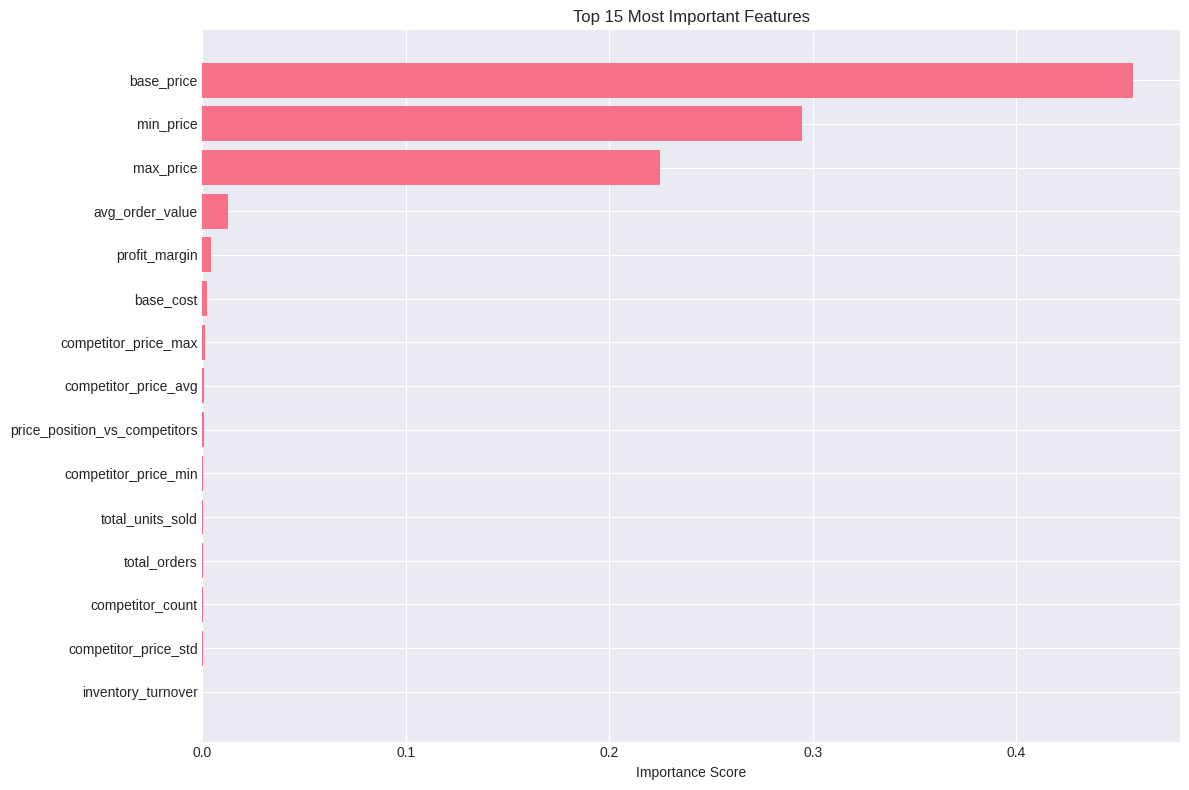

,feature,importance
0,base_price,0.457676
2,min_price,0.294777
3,max_price,0.225141
18,avg_order_value,0.012729
22,profit_margin,0.004160
1,base_cost,0.002320
7,competitor_price_max,0.001173
5,competitor_price_avg,0.000755
19,price_position_vs_competitors,0.000591
6,competitor_price_min,0.000222


In [37]:
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance['feature'].head(15), feature_importance['importance'].head(15))
plt.xlabel('Importance Score')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

feature_importance.head(10)

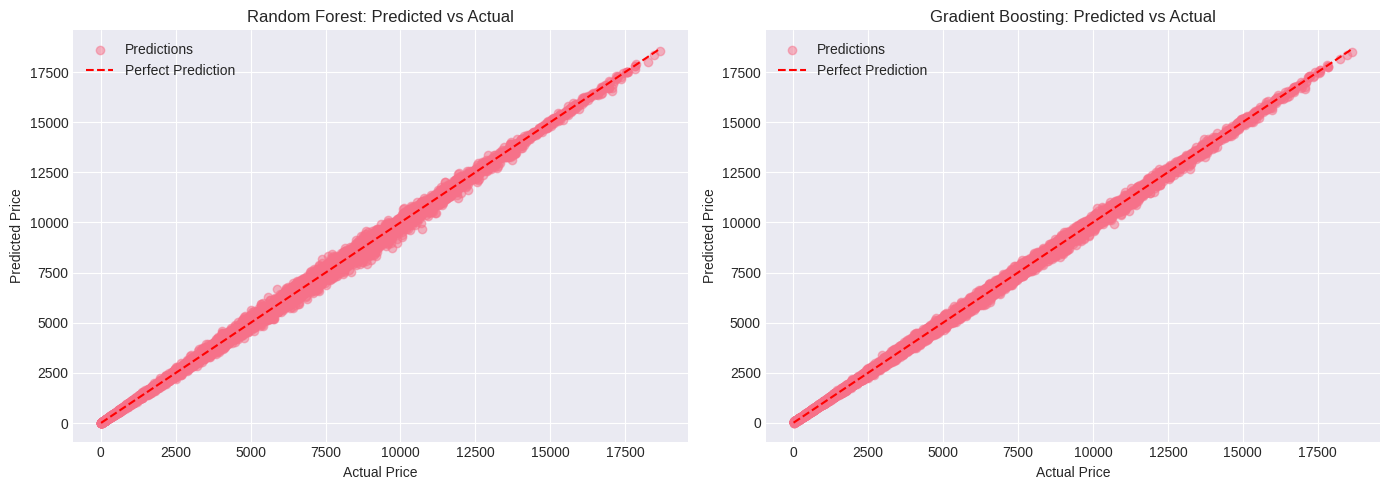

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_test, rf_predictions, alpha=0.5, label='Predictions')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', label='Perfect Prediction')
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].set_title('Random Forest: Predicted vs Actual')
axes[0].legend()

axes[1].scatter(y_test, gb_predictions, alpha=0.5, label='Predictions')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', label='Perfect Prediction')
axes[1].set_xlabel('Actual Price')
axes[1].set_ylabel('Predicted Price')
axes[1].set_title('Gradient Boosting: Predicted vs Actual')
axes[1].legend()

plt.tight_layout()
plt.show()

## Train Models

In [39]:
model_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting'],
    'MAE': [rf_mae, gb_mae],
    'RMSE': [rf_rmse, gb_rmse],
    'R² Score': [rf_r2, gb_r2]
})

best_model = rf_model if rf_r2 > gb_r2 else gb_model
best_model_name = 'Random Forest' if rf_r2 > gb_r2 else 'Gradient Boosting'

model_comparison

,Model,MAE,RMSE,R² Score
0,Random Forest,111.327587,161.653508,0.998315
1,Gradient Boosting,96.115979,130.762640,0.998897


In [40]:
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)

gb_mae = mean_absolute_error(y_test, gb_predictions)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_predictions))
gb_r2 = r2_score(y_test, gb_predictions)

In [41]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = r2_score(y_test, rf_predictions)

## Prepare Model Data

In [42]:
X = model_data[feature_columns]
y = model_data[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
feature_columns = [
    'base_price', 'base_cost', 'min_price', 'max_price',
    'quantity_available',
    'competitor_price_avg', 'competitor_price_min', 'competitor_price_max', 
    'competitor_price_std', 'competitor_count',
    'total_views_30d', 'total_cart_adds_30d', 'total_purchases_30d',
    'avg_conversion_rate', 'avg_abandonment_rate', 'avg_demand_score',
    'total_units_sold', 'total_orders', 'avg_order_value',
    'price_position_vs_competitors', 'inventory_turnover',
    'revenue_per_view', 'profit_margin', 'price_elasticity_proxy'
]

target_column = 'current_price'

model_data = pricing_data[feature_columns + [target_column]].copy()
model_data = model_data.replace([np.inf, -np.inf], 0).fillna(0)

Create derived features for better predictions

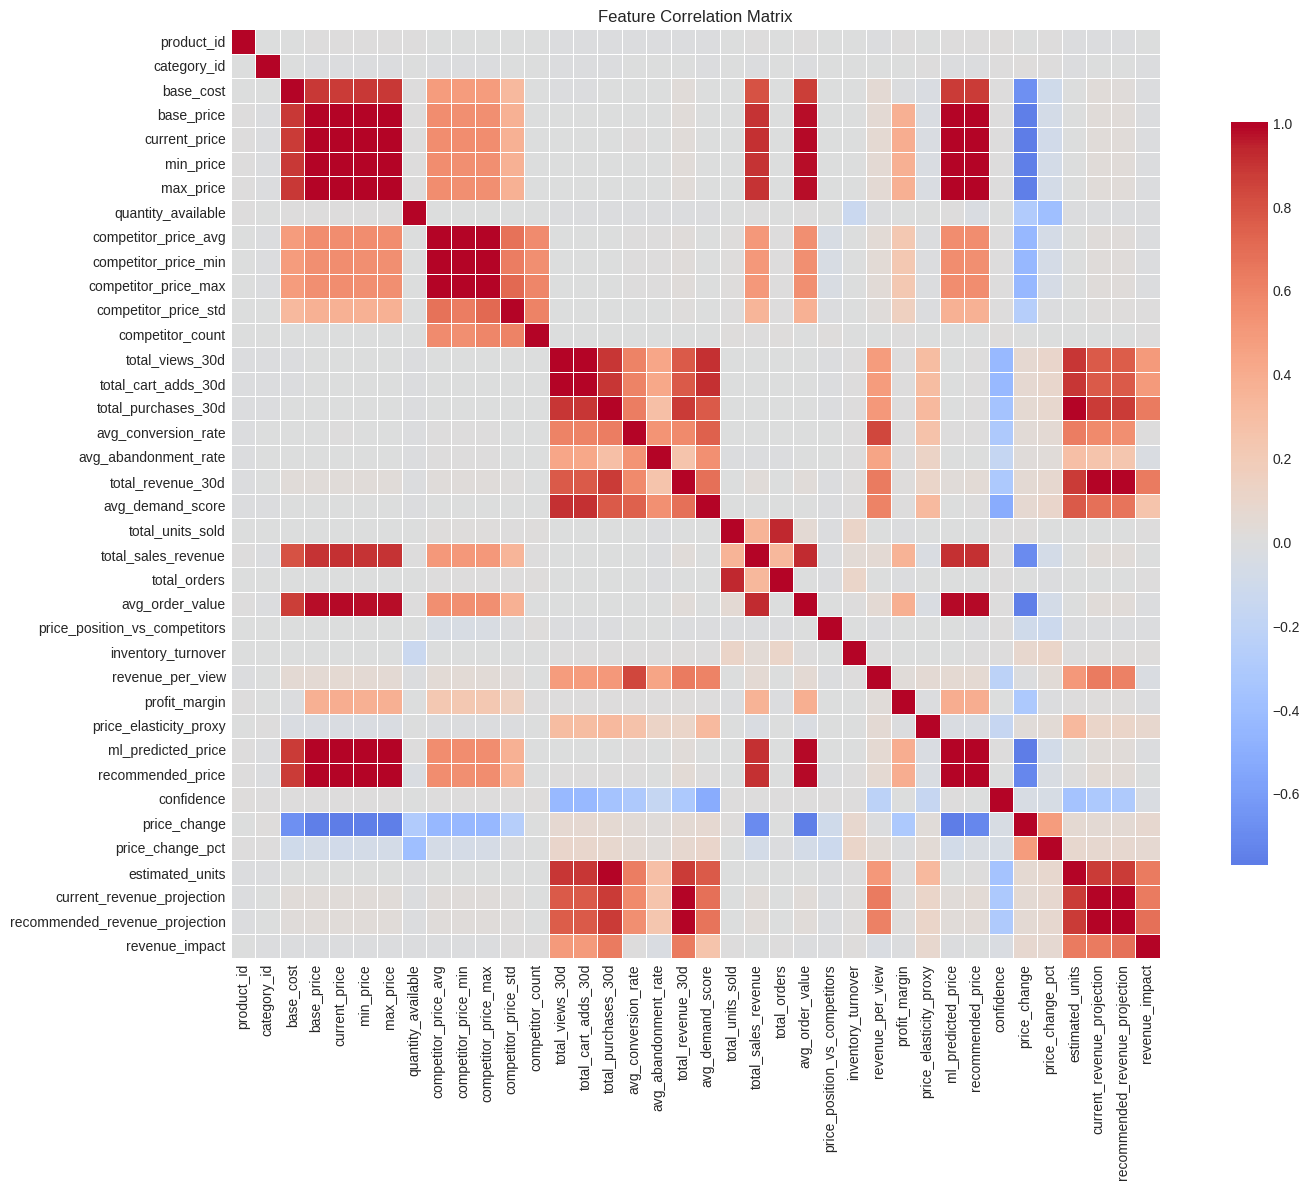

current_price           1.000000
ml_predicted_price      0.999624
recommended_price       0.996926
max_price               0.994386
base_price              0.994386
min_price               0.994386
avg_order_value         0.983661
total_sales_revenue     0.905850
base_cost               0.877753
competitor_price_avg    0.553162
Name: current_price, dtype: float64

In [44]:
numeric_cols = pricing_data.select_dtypes(include=[np.number]).columns
correlation_matrix = pricing_data[numeric_cols].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

correlation_matrix['current_price'].sort_values(ascending=False).head(10)

Calculate demand metrics from last 30 days

In [45]:
pricing_data['price_position_vs_competitors'] = (
    (pricing_data['current_price'] - pricing_data['competitor_price_avg']) / 
    pricing_data['competitor_price_avg'] * 100
)

pricing_data['inventory_turnover'] = (
    pricing_data['total_units_sold'] / pricing_data['quantity_available']
)

pricing_data['revenue_per_view'] = (
    pricing_data['total_revenue_30d'] / pricing_data['total_views_30d']
)

pricing_data['profit_margin'] = (
    (pricing_data['current_price'] - pricing_data['base_cost']) / pricing_data['current_price'] * 100
)

pricing_data['price_elasticity_proxy'] = (
    pricing_data['total_purchases_30d'] / pricing_data['current_price']
)

pricing_data.fillna(0, inplace=True)
pricing_data.replace([np.inf, -np.inf], 0, inplace=True)

In [46]:
pricing_data = products.copy()

pricing_data = pricing_data.merge(inventory[['product_id', 'quantity_available', 'stock_status']], 
                                  on='product_id', how='left')

pricing_data = pricing_data.merge(competitor_features, on='product_id', how='left')

pricing_data = pricing_data.merge(demand_features, on='product_id', how='left')

pricing_data = pricing_data.merge(sales_features, on='product_id', how='left')

pricing_data = pricing_data.merge(categories[['category_id', 'category_name']], 
                                  on='category_id', how='left')

In [47]:
sales_features = order_items.groupby('product_id').agg({
    'quantity': 'sum',
    'total_price': 'sum',
    'order_id': 'count'
}).reset_index()

sales_features.columns = ['product_id', 'total_units_sold', 'total_sales_revenue', 'total_orders']
sales_features['avg_order_value'] = (sales_features['total_sales_revenue'] / 
                                     sales_features['total_orders']).round(2)

In [48]:
demand_metrics['date'] = pd.to_datetime(demand_metrics['date'])
recent_date = demand_metrics['date'].max()
recent_cutoff = recent_date - pd.Timedelta(days=30)

recent_demand = demand_metrics[demand_metrics['date'] > recent_cutoff]

demand_features = recent_demand.groupby('product_id').agg({
    'page_views': 'sum',
    'add_to_cart_count': 'sum',
    'purchase_count': 'sum',
    'conversion_rate': 'mean',
    'cart_abandonment_rate': 'mean',
    'revenue': 'sum',
    'demand_score': 'mean'
}).reset_index()

demand_features.columns = ['product_id', 'total_views_30d', 'total_cart_adds_30d', 
                           'total_purchases_30d', 'avg_conversion_rate', 
                           'avg_abandonment_rate', 'total_revenue_30d', 'avg_demand_score']

In [49]:
competitor_features = competitor_prices.groupby('product_id').agg({
    'competitor_price': ['mean', 'min', 'max', 'std', 'count']
}).reset_index()

competitor_features.columns = ['product_id', 'competitor_price_avg', 'competitor_price_min', 
                                'competitor_price_max', 'competitor_price_std', 'competitor_count']

competitor_features['competitor_price_std'].fillna(0, inplace=True)

## Build Features

Extract competitor pricing patterns

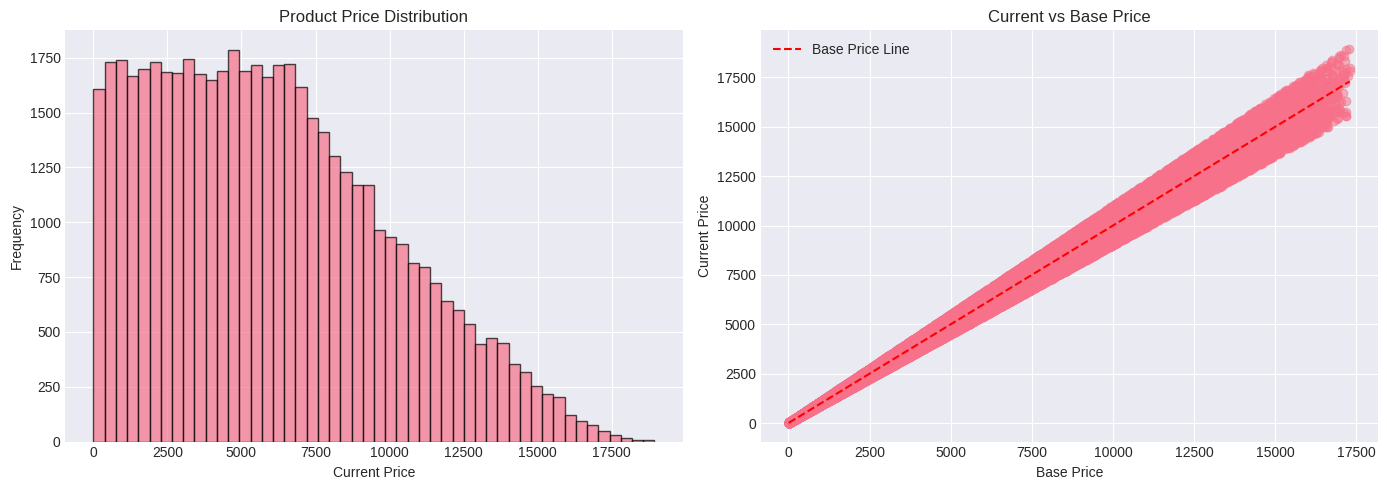

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(products['current_price'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Current Price')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Product Price Distribution')

axes[1].scatter(products['base_price'], products['current_price'], alpha=0.5)
axes[1].plot([products['base_price'].min(), products['base_price'].max()], 
             [products['base_price'].min(), products['base_price'].max()], 
             'r--', label='Base Price Line')
axes[1].set_xlabel('Base Price')
axes[1].set_ylabel('Current Price')
axes[1].set_title('Current vs Base Price')
axes[1].legend()

plt.tight_layout()
plt.show()

In [51]:
products[['base_price', 'current_price', 'min_price', 'max_price']].describe()

,base_price,current_price,min_price,max_price
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,6029.412075,6025.913347,4220.588126,9044.118106
std,3911.747124,3929.693289,2738.222989,5867.620689
min,8.240000,7.900000,5.770000,12.360000
25%,2811.532500,2796.682500,1968.075000,4217.300000
50%,5598.345000,5577.075000,3918.840000,8397.520000
75%,8689.335000,8675.630000,6082.535000,13034.002500
max,17296.600000,18937.100000,12107.620000,25944.900000


## Explore Price Distribution

In [52]:
products = pd.read_csv('csv_data/products.csv')
categories = pd.read_csv('csv_data/categories.csv')
customers = pd.read_csv('csv_data/customers.csv')
competitors = pd.read_csv('csv_data/competitors.csv')
inventory = pd.read_csv('csv_data/inventory.csv')
orders = pd.read_csv('csv_data/orders.csv')
order_items = pd.read_csv('csv_data/order_items.csv')
demand_metrics = pd.read_csv('csv_data/demand_metrics.csv')
competitor_prices = pd.read_csv('csv_data/competitor_prices.csv')
pricing_history = pd.read_csv('csv_data/pricing_history.csv')

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")